In [38]:
#| default_exp ode_correction
from nbdev.showdoc import *
import numpy as np
from tqdm.notebook import trange, tqdm
import matplotlib.pyplot as plt
import diffusion_curvature
from diffusion_curvature.core import plot_3d, diffusion_matrix, gaussian_kernel
from diffusion_curvature.datasets import *
from diffusion_curvature.normalizing_flows import *
from diffusion_curvature.comparisons import *
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Reload any changes made to external files
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Diffusion Comparison Curvature with ODE-corrected sampling

Previously, we estimated the curvature with local diffusion entropy, and compared to uniformly sampled points of the manifold's intrinsic dimension, turned into a graph with the same kernel construction as the actual point cloud.

This section adds another method to the experiment. Instead of sampling uniformly random points, we take the existing points on the manifold (those within a $k$ neighborhood of the central point), and apply a Neural ODE to "flow" these points into an approximate uniform distribution. 

The hope is that we'll thus compare against points with the *same* distribution as on the manifold - e.g. the same biases, the same clusters of density. All local variations might be approximately preserved by the ODE, allowing us to better tease apart the global variations.

# The Pipeline
Given a dataset X, this notebook will run it through a pipeline to compute curvature with the ODE-corrected sampling:
1. First, the manifold neighborhoods will be extracted around each point.
2. These will be transformed using PCA into neighborhoods of the manifold's intrinsic dimension (a crude flattening step, necessary for applying the ODE)
3. We'll then apply the ODE to learn a continuous normalization flow from each neighborhood to the closest uniform distribution.
4. Curvature will be calculated in both the original (manifold) space and on this smaller set of neurally flattened points.

In [39]:
X, ks = torus(n=4000, use_guide_points = False)
intrinsic_dimension = 2
n_neighbors = 100
ode_training_epochs = 200

We'll store the comparison spaces and computed curvatures here

In [40]:
comparison_spaces = []
computed_ks = []

The `ManifoldNeighborhoodDataset` extracts the neighborhoods and performs PCA on them. When called with each index, it returns the ambient points, and the pca points. We can visualize the effect of our neighborhood size; some experimentation will likely be required to find the appropriate number of neighbors.

In [41]:
dataset_of_neighborhoods = ManifoldNeighborhoodDataset(X, n_neighbors=n_neighbors, intrinsic_dimension=intrinsic_dimension)

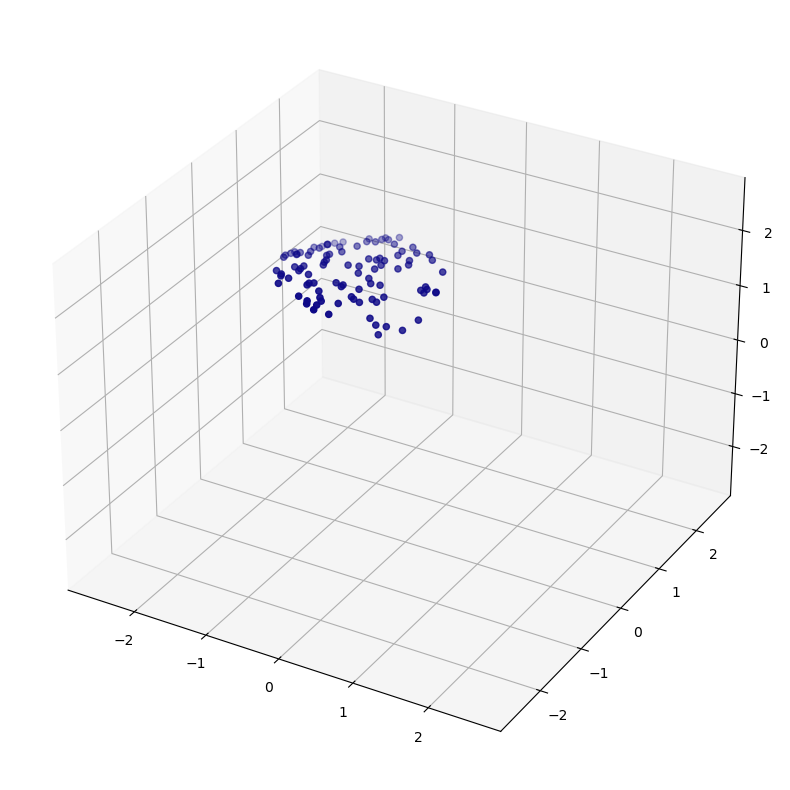

In [42]:
nbhd, pca_nbhd = dataset_of_neighborhoods.__getitem__(np.random.randint(len(X)))
plot_3d(nbhd)

In [43]:
plot_3d(nbhd,use_plotly=True)

We'll now apply our Neural Flattener to each of these neighborhoods.

In [44]:
NF = neural_flattener(device=device,max_epochs=ode_training_epochs)

In [45]:
for i in range(len(X)):
    ambient_xi, pcad_xi = dataset_of_neighborhoods[0]
    neurally_flattened_xi = NF.fit_transform(pcad_xi)
    comparison_spaces.append(neurally_flattened_xi)
    break

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/adjourner/miniforge3/envs/diffusion_curvature/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.


  | Name      | Type                            | Params
--------------------------------------------------------------
0 | model     | NeuralODE                       | 1.2 K 
1 | loss      | NegativeLogLikelihoodQuaUniform | 1.2 K 
2 | augmenter | Augmenter                       | 0     
--------------------------------------------------------------
1.2 K     Trainable params
0         Non-trainable params
1.2 K     Total params
0.005     Total estimated model params size (MB)


Your vector field callable (nn.Module) should have both time `t` and state `x` as arguments, we've wrapped it for you.


/Users/adjourner/miniforge3/envs/diffusion_curvature/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning:

The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.

/Users/adjourner/miniforge3/envs/diffusion_curvature/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:280: PossibleUserWarning:

The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=5). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.



Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.


Has anything noticeably changed between these?
It seems like the nODE is powerless to separate chunks of points, so the hyper-local density is preserved, but the overall distribution is shifted to be more uniform -- exactly as we wanted. This allows the comparison space to 

Text(0.5, 1.0, 'nODE Flattening')

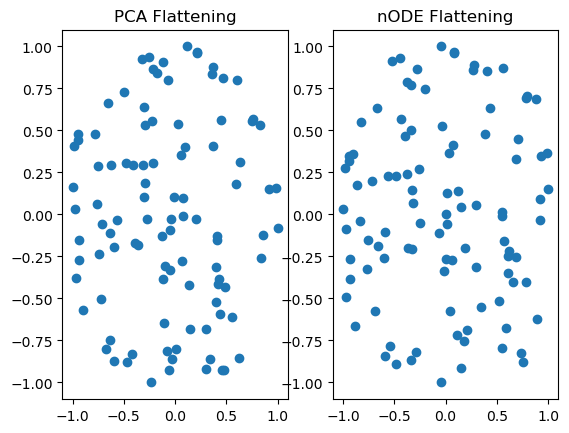

In [46]:
pca_comparison_space = dataset_of_neighborhoods[0][1]
ode_comparison_space = comparison_spaces[0]
fig, axs = plt.subplots(1,2)
axs[0].scatter(pca_comparison_space[:,0],pca_comparison_space[:,1])
axs[0].set_title("PCA Flattening")
axs[1].scatter(ode_comparison_space[:,0],ode_comparison_space[:,1])
axs[1].set_title("nODE Flattening")

Equipped with these comparison spaces, we can compute the diffusion entropy curvature.

In [47]:
comparison_ks = []
for i, comp_space in enumerate(comparison_spaces):
    comparison_ks.append(diffusion_entropy_curvature_of_data(comp_space))

In [48]:
comparison_ks

[array([4.60442906, 4.60368873, 4.60439837, 4.60397916, 4.60122417,
        4.60249807, 4.60042488, 4.59386378, 4.59426792, 4.5997098 ,
        4.59779061, 4.59651698, 4.59470496, 4.59823836, 4.59534725,
        4.59935436, 4.59607266, 4.59412229, 4.59061511, 4.58271426,
        4.59757539, 4.58383018, 4.577312  , 4.57732142, 4.59323254,
        4.57048854, 4.57889903, 4.57594665, 4.58560419, 4.58360761,
        4.58902657, 4.58620206, 4.56554282, 4.56449818, 4.57662271,
        4.57056888, 4.57207382, 4.56248218, 4.56108479, 4.58003555,
        4.56722908, 4.57194549, 4.56163119, 4.56438286, 4.55941165,
        4.57838615, 4.57976145, 4.58389831, 4.55905858, 4.56359209,
        4.57140017, 4.58051513, 4.55920072, 4.58050093, 4.5570776 ,
        4.57796037, 4.5725109 , 4.57415431, 4.57758911, 4.55902621,
        4.56805389, 4.58055175, 4.56166377, 4.57683628, 4.58935136,
        4.5611857 , 4.56419032, 4.56077011, 4.55782252, 4.57640681,
        4.57597957, 4.58162252, 4.58627655, 4.55

In [49]:
from diffusion_curvature.gaussian_invariance import compute_anisotropic_diffusion_matrix_from_graph
X_comp = comparison_spaces[0]
A_comp = gaussian_kernel(X_comp, kernel_type="adaptive",k=10)
P_comp = compute_anisotropic_diffusion_matrix_from_graph(A_comp, alpha=1)
Pt_comp = np.linalg.matrix_power(P_comp,8)

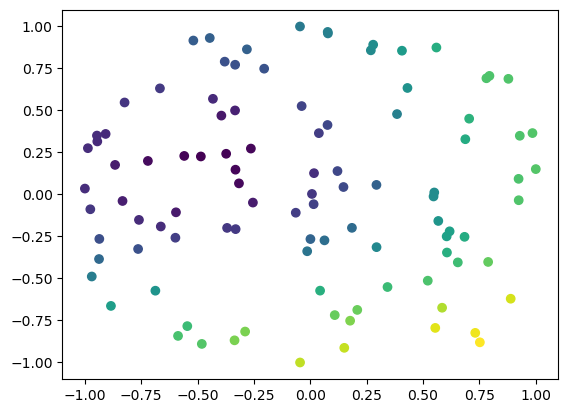

In [50]:
plt.scatter(X_comp[:,0],X_comp[:,1],c=Pt_comp[0])

In [51]:
#| export
from sklearn.decomposition import PCA
def single_point_diffusion_curvature_contra_neural_flattening(X, idx, dimension, t=8, k=10, n_neighbors = 100):
    # prepare neighborhood
    central_point = X[idx]
    # TODO: We presently assume that these neighborhoods are small enough that euclidean similarities are accurate
    distances_to_central_point = torch.linalg.norm(X - central_point, axis=1)
    neighbor_idxs = np.argpartition(distances_to_central_point,n_neighbors)[:n_neighbors]
    ambient_points = X[neighbor_idxs]
    pca = PCA(n_components=dimension)
    pca_points = pca.fit_transform(ambient_points.numpy())
    pca_points = scaler.fit_transform(pca_points)
    pca_points = torch.Tensor(pca_points)
    

In [111]:
from sklearn.decomposition import PCA
import torch, torch.nn as nn, torch.utils.data as data, torch.nn.functional as F, torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
import numpy as np
class NeuralDiffusionCurvature():
    def __init__(self, X, dimension, n_neighbors = 100,  t=8, k=10, epochs_flattening = 100, device = torch.device('cpu')):
        self.X = torch.tensor(X).float()
        self.dimension = dimension
        self.n_neighbors = n_neighbors
        self.t = t
        self.k = k
        self.scaler = MinMaxScaler(feature_range=(-1,1))
        self.PCA = PCA(n_components=dimension)
        self.NF = neural_flattener(device=device,max_epochs=epochs_flattening)
    def neighborhood_of_idx(self,idx):
        central_point = self.X[idx]
        # TODO: We presently assume that these neighborhoods are small enough that euclidean similarities are accurate
        distances_to_central_point = torch.linalg.norm(self.X - central_point, axis=1)
        neighbor_idxs = np.argsort(distances_to_central_point)[:self.n_neighbors]
        ambient_points = self.X[neighbor_idxs]
        pca_points = self.PCA.fit_transform(ambient_points.numpy())
        pca_points = self.scaler.fit_transform(pca_points)
        pca_points = torch.Tensor(pca_points)
        return ambient_points, pca_points, neighbor_idxs
    def curvature_of_idx(self,idx):
        ambient_X, pca_X, nbhd_idxs = self.neighborhood_of_idx(idx)
        self.nfd_X = self.NF.fit_transform(pca_X)
        ks_manifold = diffusion_entropy_curvature_of_data(ambient_X.numpy(), t=self.t,k=self.k)
        ks_euclidean = diffusion_entropy_curvature_of_data(self.nfd_X.detach().numpy(), t=self.t, k=self.k)
        return ks_euclidean - ks_manifold, ks_manifold, ks_euclidean, self.nfd_X
    def curvature_of_idx_contra_pca(self,idx):
        ambient_X, pca_X, nbhd_idxs = self.neighborhood_of_idx(idx)
        ks_manifold = diffusion_entropy_curvature_of_data(ambient_X.numpy(), t=self.t,k=self.k)
        ks_euclidean = diffusion_entropy_curvature_of_data(pca_X.numpy(), t=self.t, k=self.k)
        return ks_euclidean - ks_manifold


In [112]:
ndc = NeuralDiffusionCurvature(X, dimension=2, n_neighbors=100, t=6,k=5, epochs_flattening=1000)

In [113]:
ks_ode, eucs, mans, nfd_X = ndc.curvature_of_idx(500)
ks_ode[0]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/adjourner/miniforge3/envs/diffusion_curvature/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.


  | Name      | Type                            | Params
--------------------------------------------------------------
0 | model     | NeuralODE                       | 1.2 K 
1 | loss      | NegativeLogLikelihoodQuaUniform | 1.2 K 
2 | augmenter | Augmenter                       | 0     
--------------------------------------------------------------
1.2 K     Trainable params
0         Non-trainable params
1.2 K     Total params
0.005     Total estimated model params size (MB)


Your vector field callable (nn.Module) should have both time `t` and state `x` as arguments, we've wrapped it for you.


/Users/adjourner/miniforge3/envs/diffusion_curvature/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning:

The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.

/Users/adjourner/miniforge3/envs/diffusion_curvature/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:280: PossibleUserWarning:

The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=5). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.



Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1000` reached.


0.005928297196410526

In [114]:
ks[500]

0.8443415647160764

In [115]:
np.log(100)

4.605170185988092

Visualizing these diffusions:

In [118]:
ambient_X, pca_X, nbhd_idxs = ndc.neighborhood_of_idx(0)
# Visualize diffusion in ambient space
X_comp = ambient_X.numpy()
A_comp = gaussian_kernel(X_comp, kernel_type="adaptive",k=5)
P_comp = compute_anisotropic_diffusion_matrix_from_graph(A_comp, alpha=1)
Pt_comp = np.linalg.matrix_power(P_comp,6)
plot_3d(X_comp,Pt_comp[0],use_plotly=True,title="Diffusion in ambient space")

Text(0.5, 1.0, 'Diffusion in PCA Space')

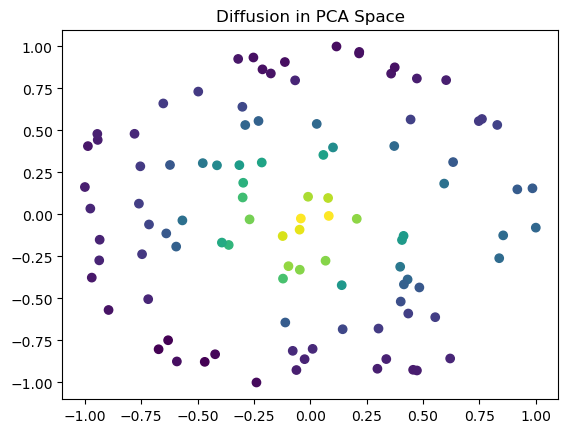

In [119]:
# Visualize diffusion in pca space
X_comp = pca_X.numpy()
A_comp = gaussian_kernel(X_comp, kernel_type="adaptive",k=5)
P_comp = compute_anisotropic_diffusion_matrix_from_graph(A_comp, alpha=1)
Pt_comp = np.linalg.matrix_power(P_comp,6)
plt.scatter(pca_X[:,0],pca_X[:,1],c=Pt_comp[0])
plt.title("Diffusion in PCA Space")

In [120]:
Pt_comp[0].max()

0.020060569176768378

In [121]:
Pt_comp[0].min()

0.005745127490453243

In [122]:
from scipy.stats import entropy
entropy(Pt_comp[0])

4.536026947494863

Text(0.5, 1.0, 'Diffusion in nODE Flattened Space')

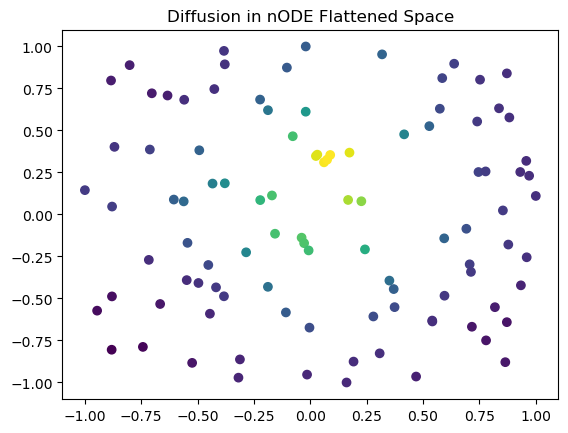

In [135]:
# Visualize diffusion in pca space
X_comp = nfd_X.numpy()
A_comp = gaussian_kernel(X_comp, kernel_type="adaptive",k=5)
P_comp = compute_anisotropic_diffusion_matrix_from_graph(A_comp, alpha=1)
Pt_comp = np.linalg.matrix_power(P_comp,4)
plt.scatter(X_comp[:,0],X_comp[:,1],c=Pt_comp[0])
plt.title("Diffusion in nODE Flattened Space")

In [137]:
t = 4
k = 5
ks_manifold = diffusion_entropy_curvature_of_data(ambient_X.numpy(), t=t,k=k)
ks_euclidean = diffusion_entropy_curvature_of_data(nfd_X.numpy(), t=t, k=k)
kss = ks_euclidean - ks_manifold

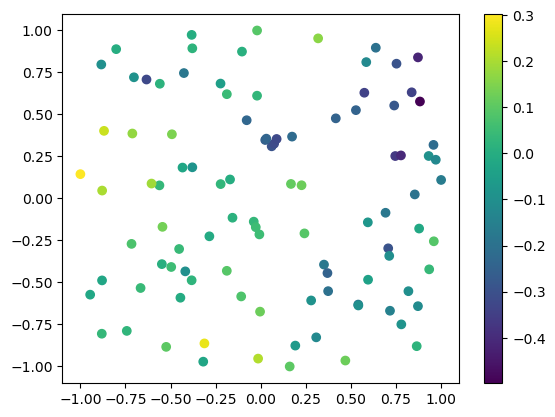

In [139]:
plt.scatter(nfd_X[:,0],nfd_X[:,1],c=kss)
plt.colorbar()

# Testing
Because of the nODE's slow training speed, applying it to every point on the torus would take around 7 hours. Instead, we'll sample a smaller number of curvatures, and compute mutual information with gaussian curvature.

In [143]:
sample_size = 50
sample_idxs = np.random.randint(len(X),size = (sample_size))
true_curvatures = ks[sample_idxs]

In [146]:
node_curvatures = []
pca_curvatures = []
averaging_k = 1
for i in tqdm(sample_idxs):
    full_node_curvatures = ndc.curvature_of_idx(i)[0]
    node_curvatures.append(full_node_curvatures[0])
    full_pca_curvatures = ndc.curvature_of_idx_contra_pca(i)[0]
    pca_curvatures.append(full_pca_curvatures)

  0%|          | 0/50 [00:00<?, ?it/s]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/adjourner/miniforge3/envs/diffusion_curvature/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.


  | Name      | Type                            | Params
--------------------------------------------------------------
0 | model     | NeuralODE                       | 1.2 K 
1 | loss      | NegativeLogLikelihoodQuaUniform | 1.2 K 
2 | augmenter | Augmenter                       | 0     
--------------------------------------------------------------
1.2 K     Trainable params
0         Non-trainable params
1.2 K     Total params
0.005     Total estimated model params size (MB)


Your vector field callable (nn.Module) should have both time `t` and state `x` as arguments, we've wrapped it for you.


/Users/adjourner/miniforge3/envs/diffusion_curvature/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning:

The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.

/Users/adjourner/miniforge3/envs/diffusion_curvature/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:280: PossibleUserWarning:

The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=5). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.



Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/adjourner/miniforge3/envs/diffusion_curvature/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.


  | Name      | Type                            | Params
--------------------------------------------------------------
0 | model     | NeuralODE                       | 1.2 K 
1 | loss      | NegativeLogLikelihoodQuaUniform | 1.2 K 
2 | augmenter | Augmenter                       | 0     
--------------------------------------------------------------
1.2 K     Trainable params
0         Non-trainable params
1.2 K     Total params
0.005     Total estimated model params size (MB)


Your vector field callable (nn.Module) should have both time `t` and state `x` as arguments, we've wrapped it for you.


/Users/adjourner/miniforge3/envs/diffusion_curvature/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning:

The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.

/Users/adjourner/miniforge3/envs/diffusion_curvature/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:280: PossibleUserWarning:

The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=5). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.



Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/adjourner/miniforge3/envs/diffusion_curvature/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.


  | Name      | Type                            | Params
--------------------------------------------------------------
0 | model     | NeuralODE                       | 1.2 K 
1 | loss      | NegativeLogLikelihoodQuaUniform | 1.2 K 
2 | augmenter | Augmenter                       | 0     
--------------------------------------------------------------
1.2 K     Trainable params
0         Non-trainable params
1.2 K     Total params
0.005     Total estimated model params size (MB)


Your vector field callable (nn.Module) should have both time `t` and state `x` as arguments, we've wrapped it for you.


/Users/adjourner/miniforge3/envs/diffusion_curvature/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning:

The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.

/Users/adjourner/miniforge3/envs/diffusion_curvature/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:280: PossibleUserWarning:

The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=5). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.



Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/adjourner/miniforge3/envs/diffusion_curvature/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.


  | Name      | Type                            | Params
--------------------------------------------------------------
0 | model     | NeuralODE                       | 1.2 K 
1 | loss      | NegativeLogLikelihoodQuaUniform | 1.2 K 
2 | augmenter | Augmenter                       | 0     
--------------------------------------------------------------
1.2 K     Trainable params
0         Non-trainable params
1.2 K     Total params
0.005     Total estimated model params size (MB)


Your vector field callable (nn.Module) should have both time `t` and state `x` as arguments, we've wrapped it for you.


/Users/adjourner/miniforge3/envs/diffusion_curvature/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning:

The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.

/Users/adjourner/miniforge3/envs/diffusion_curvature/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:280: PossibleUserWarning:

The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=5). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.



Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/adjourner/miniforge3/envs/diffusion_curvature/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.


  | Name      | Type                            | Params
--------------------------------------------------------------
0 | model     | NeuralODE                       | 1.2 K 
1 | loss      | NegativeLogLikelihoodQuaUniform | 1.2 K 
2 | augmenter | Augmenter                       | 0     
--------------------------------------------------------------
1.2 K     Trainable params
0         Non-trainable params
1.2 K     Total params
0.005     Total estimated model params size (MB)


Your vector field callable (nn.Module) should have both time `t` and state `x` as arguments, we've wrapped it for you.


/Users/adjourner/miniforge3/envs/diffusion_curvature/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning:

The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.

/Users/adjourner/miniforge3/envs/diffusion_curvature/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:280: PossibleUserWarning:

The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=5). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.



Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/adjourner/miniforge3/envs/diffusion_curvature/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.


  | Name      | Type                            | Params
--------------------------------------------------------------
0 | model     | NeuralODE                       | 1.2 K 
1 | loss      | NegativeLogLikelihoodQuaUniform | 1.2 K 
2 | augmenter | Augmenter                       | 0     
--------------------------------------------------------------
1.2 K     Trainable params
0         Non-trainable params
1.2 K     Total params
0.005     Total estimated model params size (MB)


Your vector field callable (nn.Module) should have both time `t` and state `x` as arguments, we've wrapped it for you.


/Users/adjourner/miniforge3/envs/diffusion_curvature/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning:

The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.

/Users/adjourner/miniforge3/envs/diffusion_curvature/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:280: PossibleUserWarning:

The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=5). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.



Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/adjourner/miniforge3/envs/diffusion_curvature/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.


  | Name      | Type                            | Params
--------------------------------------------------------------
0 | model     | NeuralODE                       | 1.2 K 
1 | loss      | NegativeLogLikelihoodQuaUniform | 1.2 K 
2 | augmenter | Augmenter                       | 0     
--------------------------------------------------------------
1.2 K     Trainable params
0         Non-trainable params
1.2 K     Total params
0.005     Total estimated model params size (MB)


Your vector field callable (nn.Module) should have both time `t` and state `x` as arguments, we've wrapped it for you.


/Users/adjourner/miniforge3/envs/diffusion_curvature/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning:

The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.

/Users/adjourner/miniforge3/envs/diffusion_curvature/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:280: PossibleUserWarning:

The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=5). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.



Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1000` reached.


Your vector field callable (nn.Module) should have both time `t` and state `x` as arguments, we've wrapped it for you.


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/adjourner/miniforge3/envs/diffusion_curvature/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.


  | Name      | Type                            | Params
--------------------------------------------------------------
0 | model     | NeuralODE                       | 1.2 K 
1 | loss      | NegativeLogLikelihoodQuaUniform | 1.2 K 
2 | augmenter | Augmenter                       | 0     
--------------------------------------------------------------
1.2 K     Trainable params
0         Non-trainable params
1.2 K     Total params
0.005     Total estimated model params size (MB)
/Users/adjourner/miniforge3/envs/diffusion_curvature/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/adjourner/miniforge3/envs/diffusion_curvature/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.


  | Name      | Type                            | Params
--------------------------------------------------------------
0 | model     | NeuralODE                       | 1.2 K 
1 | loss      | NegativeLogLikelihoodQuaUniform | 1.2 K 
2 | augmenter | Augmenter                       | 0     
--------------------------------------------------------------
1.2 K     Trainable params
0         Non-trainable params
1.2 K     Total params
0.005     Total estimated model params size (MB)


Your vector field callable (nn.Module) should have both time `t` and state `x` as arguments, we've wrapped it for you.


/Users/adjourner/miniforge3/envs/diffusion_curvature/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning:

The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.

/Users/adjourner/miniforge3/envs/diffusion_curvature/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:280: PossibleUserWarning:

The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=5). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.



Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/adjourner/miniforge3/envs/diffusion_curvature/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.


  | Name      | Type                            | Params
--------------------------------------------------------------
0 | model     | NeuralODE                       | 1.2 K 
1 | loss      | NegativeLogLikelihoodQuaUniform | 1.2 K 
2 | augmenter | Augmenter                       | 0     
--------------------------------------------------------------
1.2 K     Trainable params
0         Non-trainable params
1.2 K     Total params
0.005     Total estimated model params size (MB)


Your vector field callable (nn.Module) should have both time `t` and state `x` as arguments, we've wrapped it for you.


/Users/adjourner/miniforge3/envs/diffusion_curvature/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning:

The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.

/Users/adjourner/miniforge3/envs/diffusion_curvature/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:280: PossibleUserWarning:

The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=5). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.



Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/adjourner/miniforge3/envs/diffusion_curvature/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.


  | Name      | Type                            | Params
--------------------------------------------------------------
0 | model     | NeuralODE                       | 1.2 K 
1 | loss      | NegativeLogLikelihoodQuaUniform | 1.2 K 
2 | augmenter | Augmenter                       | 0     
--------------------------------------------------------------
1.2 K     Trainable params
0         Non-trainable params
1.2 K     Total params
0.005     Total estimated model params size (MB)
/Users/adjourner/miniforge3/envs/diffusion_curvature/lib/python3.10/s

Your vector field callable (nn.Module) should have both time `t` and state `x` as arguments, we've wrapped it for you.


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/adjourner/miniforge3/envs/diffusion_curvature/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.


  | Name      | Type                            | Params
--------------------------------------------------------------
0 | model     | NeuralODE                       | 1.2 K 
1 | loss      | NegativeLogLikelihoodQuaUniform | 1.2 K 
2 | augmenter | Augmenter                       | 0     
--------------------------------------------------------------
1.2 K     Trainable params
0         Non-trainable params
1.2 K     Total params
0.005     Total estimated model params size (MB)


Your vector field callable (nn.Module) should have both time `t` and state `x` as arguments, we've wrapped it for you.


/Users/adjourner/miniforge3/envs/diffusion_curvature/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning:

The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.

/Users/adjourner/miniforge3/envs/diffusion_curvature/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:280: PossibleUserWarning:

The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=5). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.



Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/adjourner/miniforge3/envs/diffusion_curvature/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.


  | Name      | Type                            | Params
--------------------------------------------------------------
0 | model     | NeuralODE                       | 1.2 K 
1 | loss      | NegativeLogLikelihoodQuaUniform | 1.2 K 
2 | augmenter | Augmenter                       | 0     
--------------------------------------------------------------
1.2 K     Trainable params
0         Non-trainable params
1.2 K     Total params
0.005     Total estimated model params size (MB)


Your vector field callable (nn.Module) should have both time `t` and state `x` as arguments, we've wrapped it for you.


/Users/adjourner/miniforge3/envs/diffusion_curvature/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning:

The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.

/Users/adjourner/miniforge3/envs/diffusion_curvature/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:280: PossibleUserWarning:

The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=5). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.



Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/adjourner/miniforge3/envs/diffusion_curvature/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.


  | Name      | Type                            | Params
--------------------------------------------------------------
0 | model     | NeuralODE                       | 1.2 K 
1 | loss      | NegativeLogLikelihoodQuaUniform | 1.2 K 
2 | augmenter | Augmenter                       | 0     
--------------------------------------------------------------
1.2 K     Trainable params
0         Non-trainable params
1.2 K     Total params
0.005     Total estimated model params size (MB)


Your vector field callable (nn.Module) should have both time `t` and state `x` as arguments, we've wrapped it for you.


/Users/adjourner/miniforge3/envs/diffusion_curvature/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning:

The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.

/Users/adjourner/miniforge3/envs/diffusion_curvature/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:280: PossibleUserWarning:

The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=5). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.



Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/adjourner/miniforge3/envs/diffusion_curvature/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.


  | Name      | Type                            | Params
--------------------------------------------------------------
0 | model     | NeuralODE                       | 1.2 K 
1 | loss      | NegativeLogLikelihoodQuaUniform | 1.2 K 
2 | augmenter | Augmenter                       | 0     
--------------------------------------------------------------
1.2 K     Trainable params
0         Non-trainable params
1.2 K     Total params
0.005     Total estimated model params size (MB)


Your vector field callable (nn.Module) should have both time `t` and state `x` as arguments, we've wrapped it for you.


/Users/adjourner/miniforge3/envs/diffusion_curvature/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning:

The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.

/Users/adjourner/miniforge3/envs/diffusion_curvature/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:280: PossibleUserWarning:

The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=5). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.



Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/adjourner/miniforge3/envs/diffusion_curvature/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.


  | Name      | Type                            | Params
--------------------------------------------------------------
0 | model     | NeuralODE                       | 1.2 K 
1 | loss      | NegativeLogLikelihoodQuaUniform | 1.2 K 
2 | augmenter | Augmenter                       | 0     
--------------------------------------------------------------
1.2 K     Trainable params
0         Non-trainable params
1.2 K     Total params
0.005     Total estimated model params size (MB)


Your vector field callable (nn.Module) should have both time `t` and state `x` as arguments, we've wrapped it for you.


/Users/adjourner/miniforge3/envs/diffusion_curvature/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning:

The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.

/Users/adjourner/miniforge3/envs/diffusion_curvature/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:280: PossibleUserWarning:

The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=5). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.



Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/adjourner/miniforge3/envs/diffusion_curvature/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.


  | Name      | Type                            | Params
--------------------------------------------------------------
0 | model     | NeuralODE                       | 1.2 K 
1 | loss      | NegativeLogLikelihoodQuaUniform | 1.2 K 
2 | augmenter | Augmenter                       | 0     
--------------------------------------------------------------
1.2 K     Trainable params
0         Non-trainable params
1.2 K     Total params
0.005     Total estimated model params size (MB)


Your vector field callable (nn.Module) should have both time `t` and state `x` as arguments, we've wrapped it for you.


/Users/adjourner/miniforge3/envs/diffusion_curvature/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning:

The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.

/Users/adjourner/miniforge3/envs/diffusion_curvature/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:280: PossibleUserWarning:

The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=5). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.



Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/adjourner/miniforge3/envs/diffusion_curvature/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.


  | Name      | Type                            | Params
--------------------------------------------------------------
0 | model     | NeuralODE                       | 1.2 K 
1 | loss      | NegativeLogLikelihoodQuaUniform | 1.2 K 
2 | augmenter | Augmenter                       | 0     
--------------------------------------------------------------
1.2 K     Trainable params
0         Non-trainable params
1.2 K     Total params
0.005     Total estimated model params size (MB)


Your vector field callable (nn.Module) should have both time `t` and state `x` as arguments, we've wrapped it for you.


/Users/adjourner/miniforge3/envs/diffusion_curvature/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning:

The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.

/Users/adjourner/miniforge3/envs/diffusion_curvature/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:280: PossibleUserWarning:

The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=5). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.



Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/adjourner/miniforge3/envs/diffusion_curvature/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.


  | Name      | Type                            | Params
--------------------------------------------------------------
0 | model     | NeuralODE                       | 1.2 K 
1 | loss      | NegativeLogLikelihoodQuaUniform | 1.2 K 
2 | augmenter | Augmenter                       | 0     
--------------------------------------------------------------
1.2 K     Trainable params
0         Non-trainable params
1.2 K     Total params
0.005     Total estimated model params size (MB)


Your vector field callable (nn.Module) should have both time `t` and state `x` as arguments, we've wrapped it for you.


/Users/adjourner/miniforge3/envs/diffusion_curvature/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning:

The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.

/Users/adjourner/miniforge3/envs/diffusion_curvature/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:280: PossibleUserWarning:

The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=5). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.



Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/adjourner/miniforge3/envs/diffusion_curvature/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.


  | Name      | Type                            | Params
--------------------------------------------------------------
0 | model     | NeuralODE                       | 1.2 K 
1 | loss      | NegativeLogLikelihoodQuaUniform | 1.2 K 
2 | augmenter | Augmenter                       | 0     
--------------------------------------------------------------
1.2 K     Trainable params
0         Non-trainable params
1.2 K     Total params
0.005     Total estimated model params size (MB)


Your vector field callable (nn.Module) should have both time `t` and state `x` as arguments, we've wrapped it for you.


/Users/adjourner/miniforge3/envs/diffusion_curvature/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning:

The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.

/Users/adjourner/miniforge3/envs/diffusion_curvature/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:280: PossibleUserWarning:

The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=5). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.



Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/adjourner/miniforge3/envs/diffusion_curvature/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.


  | Name      | Type                            | Params
--------------------------------------------------------------
0 | model     | NeuralODE                       | 1.2 K 
1 | loss      | NegativeLogLikelihoodQuaUniform | 1.2 K 
2 | augmenter | Augmenter                       | 0     
--------------------------------------------------------------
1.2 K     Trainable params
0         Non-trainable params
1.2 K     Total params
0.005     Total estimated model params size (MB)


Your vector field callable (nn.Module) should have both time `t` and state `x` as arguments, we've wrapped it for you.


/Users/adjourner/miniforge3/envs/diffusion_curvature/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning:

The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.

/Users/adjourner/miniforge3/envs/diffusion_curvature/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:280: PossibleUserWarning:

The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=5). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.



Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/adjourner/miniforge3/envs/diffusion_curvature/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.


  | Name      | Type                            | Params
--------------------------------------------------------------
0 | model     | NeuralODE                       | 1.2 K 
1 | loss      | NegativeLogLikelihoodQuaUniform | 1.2 K 
2 | augmenter | Augmenter                       | 0     
--------------------------------------------------------------
1.2 K     Trainable params
0         Non-trainable params
1.2 K     Total params
0.005     Total estimated model params size (MB)


Your vector field callable (nn.Module) should have both time `t` and state `x` as arguments, we've wrapped it for you.


/Users/adjourner/miniforge3/envs/diffusion_curvature/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning:

The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.

/Users/adjourner/miniforge3/envs/diffusion_curvature/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:280: PossibleUserWarning:

The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=5). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.



Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/adjourner/miniforge3/envs/diffusion_curvature/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.


  | Name      | Type                            | Params
--------------------------------------------------------------
0 | model     | NeuralODE                       | 1.2 K 
1 | loss      | NegativeLogLikelihoodQuaUniform | 1.2 K 
2 | augmenter | Augmenter                       | 0     
--------------------------------------------------------------
1.2 K     Trainable params
0         Non-trainable params
1.2 K     Total params
0.005     Total estimated model params size (MB)


Your vector field callable (nn.Module) should have both time `t` and state `x` as arguments, we've wrapped it for you.


/Users/adjourner/miniforge3/envs/diffusion_curvature/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning:

The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.

/Users/adjourner/miniforge3/envs/diffusion_curvature/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:280: PossibleUserWarning:

The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=5). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.



Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/adjourner/miniforge3/envs/diffusion_curvature/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.


  | Name      | Type                            | Params
--------------------------------------------------------------
0 | model     | NeuralODE                       | 1.2 K 
1 | loss      | NegativeLogLikelihoodQuaUniform | 1.2 K 
2 | augmenter | Augmenter                       | 0     
--------------------------------------------------------------
1.2 K     Trainable params
0         Non-trainable params
1.2 K     Total params
0.005     Total estimated model params size (MB)


Your vector field callable (nn.Module) should have both time `t` and state `x` as arguments, we've wrapped it for you.


/Users/adjourner/miniforge3/envs/diffusion_curvature/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning:

The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.

/Users/adjourner/miniforge3/envs/diffusion_curvature/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:280: PossibleUserWarning:

The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=5). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.



Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/adjourner/miniforge3/envs/diffusion_curvature/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.


  | Name      | Type                            | Params
--------------------------------------------------------------
0 | model     | NeuralODE                       | 1.2 K 
1 | loss      | NegativeLogLikelihoodQuaUniform | 1.2 K 
2 | augmenter | Augmenter                       | 0     
--------------------------------------------------------------
1.2 K     Trainable params
0         Non-trainable params
1.2 K     Total params
0.005     Total estimated model params size (MB)


Your vector field callable (nn.Module) should have both time `t` and state `x` as arguments, we've wrapped it for you.


/Users/adjourner/miniforge3/envs/diffusion_curvature/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning:

The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.

/Users/adjourner/miniforge3/envs/diffusion_curvature/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:280: PossibleUserWarning:

The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=5). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.



Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/adjourner/miniforge3/envs/diffusion_curvature/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.


  | Name      | Type                            | Params
--------------------------------------------------------------
0 | model     | NeuralODE                       | 1.2 K 
1 | loss      | NegativeLogLikelihoodQuaUniform | 1.2 K 
2 | augmenter | Augmenter                       | 0     
--------------------------------------------------------------
1.2 K     Trainable params
0         Non-trainable params
1.2 K     Total params
0.005     Total estimated model params size (MB)


Your vector field callable (nn.Module) should have both time `t` and state `x` as arguments, we've wrapped it for you.


/Users/adjourner/miniforge3/envs/diffusion_curvature/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning:

The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.

/Users/adjourner/miniforge3/envs/diffusion_curvature/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:280: PossibleUserWarning:

The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=5). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.



Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/adjourner/miniforge3/envs/diffusion_curvature/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.


  | Name      | Type                            | Params
--------------------------------------------------------------
0 | model     | NeuralODE                       | 1.2 K 
1 | loss      | NegativeLogLikelihoodQuaUniform | 1.2 K 
2 | augmenter | Augmenter                       | 0     
--------------------------------------------------------------
1.2 K     Trainable params
0         Non-trainable params
1.2 K     Total params
0.005     Total estimated model params size (MB)


Your vector field callable (nn.Module) should have both time `t` and state `x` as arguments, we've wrapped it for you.


/Users/adjourner/miniforge3/envs/diffusion_curvature/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning:

The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.

/Users/adjourner/miniforge3/envs/diffusion_curvature/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:280: PossibleUserWarning:

The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=5). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.



Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/adjourner/miniforge3/envs/diffusion_curvature/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.


  | Name      | Type                            | Params
--------------------------------------------------------------
0 | model     | NeuralODE                       | 1.2 K 
1 | loss      | NegativeLogLikelihoodQuaUniform | 1.2 K 
2 | augmenter | Augmenter                       | 0     
--------------------------------------------------------------
1.2 K     Trainable params
0         Non-trainable params
1.2 K     Total params
0.005     Total estimated model params size (MB)


Your vector field callable (nn.Module) should have both time `t` and state `x` as arguments, we've wrapped it for you.


/Users/adjourner/miniforge3/envs/diffusion_curvature/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning:

The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.

/Users/adjourner/miniforge3/envs/diffusion_curvature/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:280: PossibleUserWarning:

The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=5). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.



Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/adjourner/miniforge3/envs/diffusion_curvature/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.


  | Name      | Type                            | Params
--------------------------------------------------------------
0 | model     | NeuralODE                       | 1.2 K 
1 | loss      | NegativeLogLikelihoodQuaUniform | 1.2 K 
2 | augmenter | Augmenter                       | 0     
--------------------------------------------------------------
1.2 K     Trainable params
0         Non-trainable params
1.2 K     Total params
0.005     Total estimated model params size (MB)


Your vector field callable (nn.Module) should have both time `t` and state `x` as arguments, we've wrapped it for you.


/Users/adjourner/miniforge3/envs/diffusion_curvature/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning:

The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.

/Users/adjourner/miniforge3/envs/diffusion_curvature/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:280: PossibleUserWarning:

The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=5). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.



Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/adjourner/miniforge3/envs/diffusion_curvature/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.


  | Name      | Type                            | Params
--------------------------------------------------------------
0 | model     | NeuralODE                       | 1.2 K 
1 | loss      | NegativeLogLikelihoodQuaUniform | 1.2 K 
2 | augmenter | Augmenter                       | 0     
--------------------------------------------------------------
1.2 K     Trainable params
0         Non-trainable params
1.2 K     Total params
0.005     Total estimated model params size (MB)


Your vector field callable (nn.Module) should have both time `t` and state `x` as arguments, we've wrapped it for you.


/Users/adjourner/miniforge3/envs/diffusion_curvature/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning:

The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.

/Users/adjourner/miniforge3/envs/diffusion_curvature/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:280: PossibleUserWarning:

The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=5). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.



Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/adjourner/miniforge3/envs/diffusion_curvature/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.


  | Name      | Type                            | Params
--------------------------------------------------------------
0 | model     | NeuralODE                       | 1.2 K 
1 | loss      | NegativeLogLikelihoodQuaUniform | 1.2 K 
2 | augmenter | Augmenter                       | 0     
--------------------------------------------------------------
1.2 K     Trainable params
0         Non-trainable params
1.2 K     Total params
0.005     Total estimated model params size (MB)


Your vector field callable (nn.Module) should have both time `t` and state `x` as arguments, we've wrapped it for you.


/Users/adjourner/miniforge3/envs/diffusion_curvature/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning:

The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.

/Users/adjourner/miniforge3/envs/diffusion_curvature/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:280: PossibleUserWarning:

The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=5). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.



Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/adjourner/miniforge3/envs/diffusion_curvature/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.


  | Name      | Type                            | Params
--------------------------------------------------------------
0 | model     | NeuralODE                       | 1.2 K 
1 | loss      | NegativeLogLikelihoodQuaUniform | 1.2 K 
2 | augmenter | Augmenter                       | 0     
--------------------------------------------------------------
1.2 K     Trainable params
0         Non-trainable params
1.2 K     Total params
0.005     Total estimated model params size (MB)


Your vector field callable (nn.Module) should have both time `t` and state `x` as arguments, we've wrapped it for you.


/Users/adjourner/miniforge3/envs/diffusion_curvature/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning:

The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.

/Users/adjourner/miniforge3/envs/diffusion_curvature/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:280: PossibleUserWarning:

The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=5). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.



Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/adjourner/miniforge3/envs/diffusion_curvature/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.


  | Name      | Type                            | Params
--------------------------------------------------------------
0 | model     | NeuralODE                       | 1.2 K 
1 | loss      | NegativeLogLikelihoodQuaUniform | 1.2 K 
2 | augmenter | Augmenter                       | 0     
--------------------------------------------------------------
1.2 K     Trainable params
0         Non-trainable params
1.2 K     Total params
0.005     Total estimated model params size (MB)


Your vector field callable (nn.Module) should have both time `t` and state `x` as arguments, we've wrapped it for you.


/Users/adjourner/miniforge3/envs/diffusion_curvature/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning:

The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.

/Users/adjourner/miniforge3/envs/diffusion_curvature/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:280: PossibleUserWarning:

The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=5). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.



Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/adjourner/miniforge3/envs/diffusion_curvature/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.


  | Name      | Type                            | Params
--------------------------------------------------------------
0 | model     | NeuralODE                       | 1.2 K 
1 | loss      | NegativeLogLikelihoodQuaUniform | 1.2 K 
2 | augmenter | Augmenter                       | 0     
--------------------------------------------------------------
1.2 K     Trainable params
0         Non-trainable params
1.2 K     Total params
0.005     Total estimated model params size (MB)


Your vector field callable (nn.Module) should have both time `t` and state `x` as arguments, we've wrapped it for you.


/Users/adjourner/miniforge3/envs/diffusion_curvature/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning:

The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.

/Users/adjourner/miniforge3/envs/diffusion_curvature/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:280: PossibleUserWarning:

The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=5). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.



Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/adjourner/miniforge3/envs/diffusion_curvature/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.


  | Name      | Type                            | Params
--------------------------------------------------------------
0 | model     | NeuralODE                       | 1.2 K 
1 | loss      | NegativeLogLikelihoodQuaUniform | 1.2 K 
2 | augmenter | Augmenter                       | 0     
--------------------------------------------------------------
1.2 K     Trainable params
0         Non-trainable params
1.2 K     Total params
0.005     Total estimated model params size (MB)


Your vector field callable (nn.Module) should have both time `t` and state `x` as arguments, we've wrapped it for you.


/Users/adjourner/miniforge3/envs/diffusion_curvature/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning:

The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.

/Users/adjourner/miniforge3/envs/diffusion_curvature/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:280: PossibleUserWarning:

The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=5). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.



Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/adjourner/miniforge3/envs/diffusion_curvature/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.


  | Name      | Type                            | Params
--------------------------------------------------------------
0 | model     | NeuralODE                       | 1.2 K 
1 | loss      | NegativeLogLikelihoodQuaUniform | 1.2 K 
2 | augmenter | Augmenter                       | 0     
--------------------------------------------------------------
1.2 K     Trainable params
0         Non-trainable params
1.2 K     Total params
0.005     Total estimated model params size (MB)


Your vector field callable (nn.Module) should have both time `t` and state `x` as arguments, we've wrapped it for you.


/Users/adjourner/miniforge3/envs/diffusion_curvature/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning:

The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.

/Users/adjourner/miniforge3/envs/diffusion_curvature/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:280: PossibleUserWarning:

The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=5). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.



Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/adjourner/miniforge3/envs/diffusion_curvature/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.


  | Name      | Type                            | Params
--------------------------------------------------------------
0 | model     | NeuralODE                       | 1.2 K 
1 | loss      | NegativeLogLikelihoodQuaUniform | 1.2 K 
2 | augmenter | Augmenter                       | 0     
--------------------------------------------------------------
1.2 K     Trainable params
0         Non-trainable params
1.2 K     Total params
0.005     Total estimated model params size (MB)


Your vector field callable (nn.Module) should have both time `t` and state `x` as arguments, we've wrapped it for you.


/Users/adjourner/miniforge3/envs/diffusion_curvature/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning:

The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.

/Users/adjourner/miniforge3/envs/diffusion_curvature/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:280: PossibleUserWarning:

The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=5). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.



Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/adjourner/miniforge3/envs/diffusion_curvature/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.


  | Name      | Type                            | Params
--------------------------------------------------------------
0 | model     | NeuralODE                       | 1.2 K 
1 | loss      | NegativeLogLikelihoodQuaUniform | 1.2 K 
2 | augmenter | Augmenter                       | 0     
--------------------------------------------------------------
1.2 K     Trainable params
0         Non-trainable params
1.2 K     Total params
0.005     Total estimated model params size (MB)


Your vector field callable (nn.Module) should have both time `t` and state `x` as arguments, we've wrapped it for you.


/Users/adjourner/miniforge3/envs/diffusion_curvature/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning:

The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.

/Users/adjourner/miniforge3/envs/diffusion_curvature/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:280: PossibleUserWarning:

The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=5). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.



Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/adjourner/miniforge3/envs/diffusion_curvature/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.


  | Name      | Type                            | Params
--------------------------------------------------------------
0 | model     | NeuralODE                       | 1.2 K 
1 | loss      | NegativeLogLikelihoodQuaUniform | 1.2 K 
2 | augmenter | Augmenter                       | 0     
--------------------------------------------------------------
1.2 K     Trainable params
0         Non-trainable params
1.2 K     Total params
0.005     Total estimated model params size (MB)


Your vector field callable (nn.Module) should have both time `t` and state `x` as arguments, we've wrapped it for you.


/Users/adjourner/miniforge3/envs/diffusion_curvature/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning:

The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.

/Users/adjourner/miniforge3/envs/diffusion_curvature/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:280: PossibleUserWarning:

The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=5). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.



Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/adjourner/miniforge3/envs/diffusion_curvature/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.


  | Name      | Type                            | Params
--------------------------------------------------------------
0 | model     | NeuralODE                       | 1.2 K 
1 | loss      | NegativeLogLikelihoodQuaUniform | 1.2 K 
2 | augmenter | Augmenter                       | 0     
--------------------------------------------------------------
1.2 K     Trainable params
0         Non-trainable params
1.2 K     Total params
0.005     Total estimated model params size (MB)


Your vector field callable (nn.Module) should have both time `t` and state `x` as arguments, we've wrapped it for you.


/Users/adjourner/miniforge3/envs/diffusion_curvature/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning:

The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.

/Users/adjourner/miniforge3/envs/diffusion_curvature/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:280: PossibleUserWarning:

The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=5). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.



Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/adjourner/miniforge3/envs/diffusion_curvature/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.


  | Name      | Type                            | Params
--------------------------------------------------------------
0 | model     | NeuralODE                       | 1.2 K 
1 | loss      | NegativeLogLikelihoodQuaUniform | 1.2 K 
2 | augmenter | Augmenter                       | 0     
--------------------------------------------------------------
1.2 K     Trainable params
0         Non-trainable params
1.2 K     Total params
0.005     Total estimated model params size (MB)


Your vector field callable (nn.Module) should have both time `t` and state `x` as arguments, we've wrapped it for you.


/Users/adjourner/miniforge3/envs/diffusion_curvature/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning:

The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.

/Users/adjourner/miniforge3/envs/diffusion_curvature/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:280: PossibleUserWarning:

The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=5). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.



Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/adjourner/miniforge3/envs/diffusion_curvature/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.


  | Name      | Type                            | Params
--------------------------------------------------------------
0 | model     | NeuralODE                       | 1.2 K 
1 | loss      | NegativeLogLikelihoodQuaUniform | 1.2 K 
2 | augmenter | Augmenter                       | 0     
--------------------------------------------------------------
1.2 K     Trainable params
0         Non-trainable params
1.2 K     Total params
0.005     Total estimated model params size (MB)


Your vector field callable (nn.Module) should have both time `t` and state `x` as arguments, we've wrapped it for you.


/Users/adjourner/miniforge3/envs/diffusion_curvature/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning:

The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.

/Users/adjourner/miniforge3/envs/diffusion_curvature/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:280: PossibleUserWarning:

The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=5). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.



Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/adjourner/miniforge3/envs/diffusion_curvature/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.


  | Name      | Type                            | Params
--------------------------------------------------------------
0 | model     | NeuralODE                       | 1.2 K 
1 | loss      | NegativeLogLikelihoodQuaUniform | 1.2 K 
2 | augmenter | Augmenter                       | 0     
--------------------------------------------------------------
1.2 K     Trainable params
0         Non-trainable params
1.2 K     Total params
0.005     Total estimated model params size (MB)


Your vector field callable (nn.Module) should have both time `t` and state `x` as arguments, we've wrapped it for you.


/Users/adjourner/miniforge3/envs/diffusion_curvature/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning:

The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.

/Users/adjourner/miniforge3/envs/diffusion_curvature/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:280: PossibleUserWarning:

The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=5). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.



Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/adjourner/miniforge3/envs/diffusion_curvature/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.


  | Name      | Type                            | Params
--------------------------------------------------------------
0 | model     | NeuralODE                       | 1.2 K 
1 | loss      | NegativeLogLikelihoodQuaUniform | 1.2 K 
2 | augmenter | Augmenter                       | 0     
--------------------------------------------------------------
1.2 K     Trainable params
0         Non-trainable params
1.2 K     Total params
0.005     Total estimated model params size (MB)


Your vector field callable (nn.Module) should have both time `t` and state `x` as arguments, we've wrapped it for you.


/Users/adjourner/miniforge3/envs/diffusion_curvature/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning:

The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.

/Users/adjourner/miniforge3/envs/diffusion_curvature/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:280: PossibleUserWarning:

The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=5). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.



Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/adjourner/miniforge3/envs/diffusion_curvature/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.


  | Name      | Type                            | Params
--------------------------------------------------------------
0 | model     | NeuralODE                       | 1.2 K 
1 | loss      | NegativeLogLikelihoodQuaUniform | 1.2 K 
2 | augmenter | Augmenter                       | 0     
--------------------------------------------------------------
1.2 K     Trainable params
0         Non-trainable params
1.2 K     Total params
0.005     Total estimated model params size (MB)


Your vector field callable (nn.Module) should have both time `t` and state `x` as arguments, we've wrapped it for you.


/Users/adjourner/miniforge3/envs/diffusion_curvature/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning:

The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.

/Users/adjourner/miniforge3/envs/diffusion_curvature/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:280: PossibleUserWarning:

The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=5). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.



Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/adjourner/miniforge3/envs/diffusion_curvature/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.


  | Name      | Type                            | Params
--------------------------------------------------------------
0 | model     | NeuralODE                       | 1.2 K 
1 | loss      | NegativeLogLikelihoodQuaUniform | 1.2 K 
2 | augmenter | Augmenter                       | 0     
--------------------------------------------------------------
1.2 K     Trainable params
0         Non-trainable params
1.2 K     Total params
0.005     Total estimated model params size (MB)


Your vector field callable (nn.Module) should have both time `t` and state `x` as arguments, we've wrapped it for you.


/Users/adjourner/miniforge3/envs/diffusion_curvature/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning:

The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.

/Users/adjourner/miniforge3/envs/diffusion_curvature/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:280: PossibleUserWarning:

The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=5). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.



Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/adjourner/miniforge3/envs/diffusion_curvature/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.


  | Name      | Type                            | Params
--------------------------------------------------------------
0 | model     | NeuralODE                       | 1.2 K 
1 | loss      | NegativeLogLikelihoodQuaUniform | 1.2 K 
2 | augmenter | Augmenter                       | 0     
--------------------------------------------------------------
1.2 K     Trainable params
0         Non-trainable params
1.2 K     Total params
0.005     Total estimated model params size (MB)


Your vector field callable (nn.Module) should have both time `t` and state `x` as arguments, we've wrapped it for you.


/Users/adjourner/miniforge3/envs/diffusion_curvature/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning:

The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.

/Users/adjourner/miniforge3/envs/diffusion_curvature/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:280: PossibleUserWarning:

The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=5). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.



Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/adjourner/miniforge3/envs/diffusion_curvature/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.


  | Name      | Type                            | Params
--------------------------------------------------------------
0 | model     | NeuralODE                       | 1.2 K 
1 | loss      | NegativeLogLikelihoodQuaUniform | 1.2 K 
2 | augmenter | Augmenter                       | 0     
--------------------------------------------------------------
1.2 K     Trainable params
0         Non-trainable params
1.2 K     Total params
0.005     Total estimated model params size (MB)


Your vector field callable (nn.Module) should have both time `t` and state `x` as arguments, we've wrapped it for you.


/Users/adjourner/miniforge3/envs/diffusion_curvature/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning:

The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.

/Users/adjourner/miniforge3/envs/diffusion_curvature/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:280: PossibleUserWarning:

The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=5). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.



Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/adjourner/miniforge3/envs/diffusion_curvature/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.


  | Name      | Type                            | Params
--------------------------------------------------------------
0 | model     | NeuralODE                       | 1.2 K 
1 | loss      | NegativeLogLikelihoodQuaUniform | 1.2 K 
2 | augmenter | Augmenter                       | 0     
--------------------------------------------------------------
1.2 K     Trainable params
0         Non-trainable params
1.2 K     Total params
0.005     Total estimated model params size (MB)


Your vector field callable (nn.Module) should have both time `t` and state `x` as arguments, we've wrapped it for you.


/Users/adjourner/miniforge3/envs/diffusion_curvature/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning:

The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.

/Users/adjourner/miniforge3/envs/diffusion_curvature/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:280: PossibleUserWarning:

The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=5). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.



Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/adjourner/miniforge3/envs/diffusion_curvature/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.


  | Name      | Type                            | Params
--------------------------------------------------------------
0 | model     | NeuralODE                       | 1.2 K 
1 | loss      | NegativeLogLikelihoodQuaUniform | 1.2 K 
2 | augmenter | Augmenter                       | 0     
--------------------------------------------------------------
1.2 K     Trainable params
0         Non-trainable params
1.2 K     Total params
0.005     Total estimated model params size (MB)


Your vector field callable (nn.Module) should have both time `t` and state `x` as arguments, we've wrapped it for you.


/Users/adjourner/miniforge3/envs/diffusion_curvature/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning:

The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.

/Users/adjourner/miniforge3/envs/diffusion_curvature/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:280: PossibleUserWarning:

The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=5). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.



Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1000` reached.


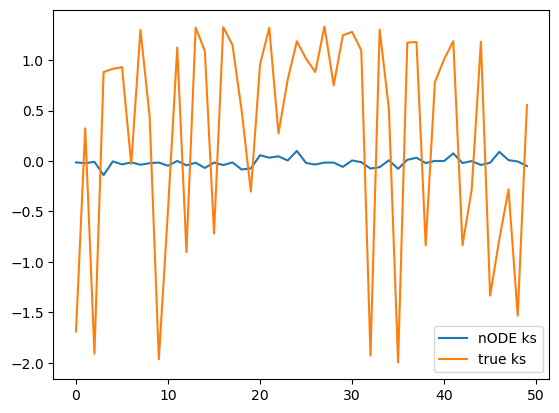

In [147]:
plt.plot(node_curvatures,label="nODE ks")
plt.plot(true_curvatures, label="true ks")
plt.legend()

In [158]:
node_curvatures_scaled = node_curvatures/np.max(np.abs(node_curvatures))

In [159]:
pca_curvatures_scaled = pca_curvatures/np.max(np.abs(pca_curvatures))

In [160]:
true_curvatures_scaled = true_curvatures/np.max(np.abs(true_curvatures))

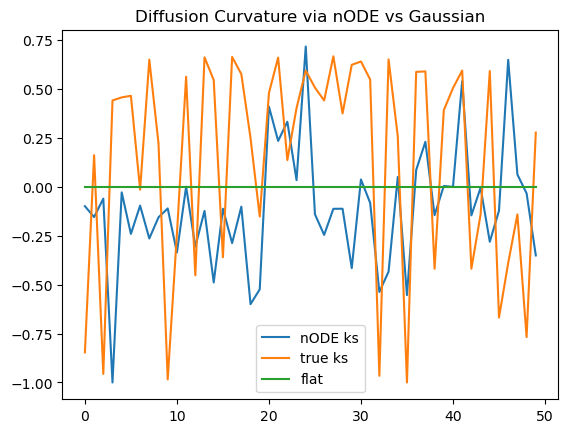

In [163]:
plt.plot(node_curvatures_scaled,label="nODE ks")
plt.plot(true_curvatures_scaled, label="true ks")
plt.plot(np.zeros(len(node_curvatures)), label="flat")
plt.title("Diffusion Curvature via nODE vs Gaussian")
plt.legend()

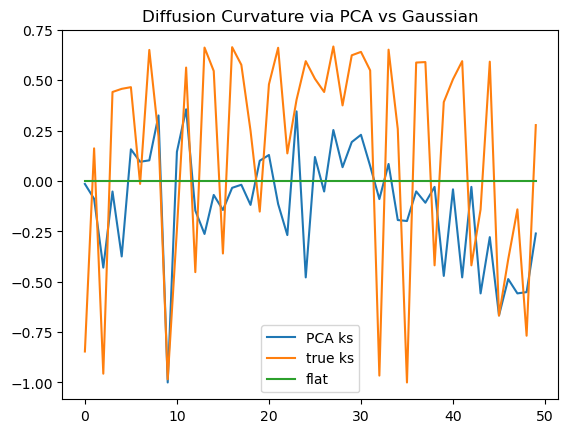

In [164]:
plt.plot(pca_curvatures_scaled,label="PCA ks")
plt.plot(true_curvatures_scaled, label="true ks")
plt.plot(np.zeros(len(node_curvatures)), label="flat")
plt.title("Diffusion Curvature via PCA vs Gaussian")
plt.legend()

In [168]:
uniform_comparison_curvatures = []
for i in tqdm(sample_idxs):
    ambient_X, pca_X, nbhd_idx = ndc.neighborhood_of_idx(i)
    dk = diffusion_curvature_contra_noise(ambient_X, dimension=2, t=6, k=5)[0]
    uniform_comparison_curvatures.append(dk)

  0%|          | 0/50 [00:00<?, ?it/s]

In [169]:
uniform_comparison_curvatures = uniform_comparison_curvatures/np.max(np.abs(uniform_comparison_curvatures))

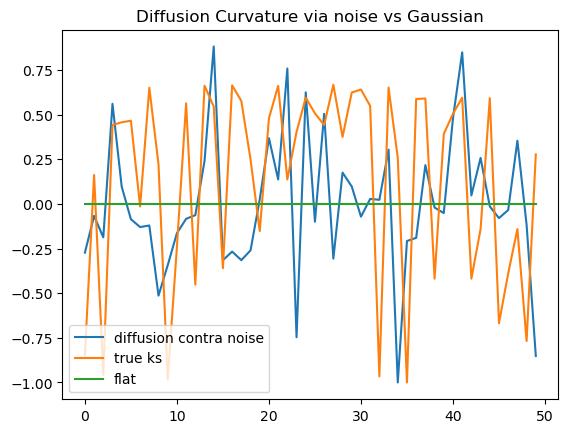

In [171]:
plt.plot(uniform_comparison_curvatures,label="diffusion contra noise")
plt.plot(true_curvatures_scaled, label="true ks")
plt.plot(np.zeros(len(node_curvatures)), label="flat")
plt.title("Diffusion Curvature via noise vs Gaussian")
plt.legend()

In [174]:
from sklearn.metrics import mutual_info_score
from scipy.stats import pearsonr
pearsonr(true_curvatures_scaled, uniform_comparison_curvatures)

PearsonRResult(statistic=0.22918200559775426, pvalue=0.10938513203926245)

In [176]:
pearsonr(true_curvatures_scaled, node_curvatures_scaled)

PearsonRResult(statistic=0.13469676044040618, pvalue=0.3510165636095415)

In [177]:
pearsonr(true_curvatures_scaled, pca_curvatures_scaled)

PearsonRResult(statistic=0.43994335947726776, pvalue=0.0013889667845612143)